In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
import tensorflow as tf
import tensorflow.contrib.learn as learn
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from pymongo import MongoClient
import ystockquote

In [4]:
from datetime import datetime, timedelta, timezone
import pytz
import math

# Load transcripts

In [5]:
client = MongoClient('localhost', 27017)
earnings_transcript_collection = client.python_import.earnings_transcript

In [6]:
earnings_transcript = pd.DataFrame(list(earnings_transcript_collection.find()))
earnings_transcript.drop('_id', axis=1, inplace=True)

In [7]:
earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
    lambda row: datetime.strptime(row['publishDate'], '%Y-%m-%dT%H:%M:%SZ'), axis=1
)

In [8]:
local_tz = pytz.timezone('US/Eastern')
def utc_to_local(utc_dt):
    local_dt = utc_dt.replace(tzinfo=pytz.utc).astimezone(local_tz)
    return local_tz.normalize(local_dt)

In [9]:
earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
    lambda row: utc_to_local(row['shifted_publishDate']), axis=1
)

In [10]:
def shift_time_according_to_closing_time(dt):
    if dt.hour >= 16:
        return dt + timedelta(days=1)
    return dt

In [11]:
earnings_transcript['shifted_publishDate'] = earnings_transcript.apply(
    lambda row: shift_time_according_to_closing_time(row['shifted_publishDate']), axis=1
)

In [12]:
earnings_transcript['publishDate_str'] = earnings_transcript.apply(
    lambda row: str(row['shifted_publishDate'].date()), 
    axis=1)
earnings_transcript.head(1)

,publishDate,qAndAText,rawText,tradingSymbol,url,shifted_publishDate,publishDate_str
0,2016-07-27T01:01:38Z,Operator Your first question will come from Sh...,"Apple, Inc. (NASDAQ: AAPL ) Q3 2016 Earnings C...",AAPL,https://seekingalpha.com/article/3991811-apple...,2016-07-27 21:01:38-04:00,2016-07-27


In [13]:
earnings_transcript.set_index(['tradingSymbol', 'publishDate_str'], inplace=True)
earnings_transcript.head(2)

publishDate  \
tradingSymbol publishDate_str                         
AAPL          2016-07-27       2016-07-27T01:01:38Z   
              2012-10-26       2012-10-26T01:33:03Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
AAPL          2016-07-27       Operator Your first question will come from Sh...   
              2012-10-26       Operator (Operator Instructions) Your first qu...   

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
AAPL          2016-07-27       Apple, Inc. (NASDAQ: AAPL ) Q3 2016 Earnings C...   
              2012-10-26       Apple Inc. (NASDAQ: AAPL ) F4Q12 Earnings Call...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
AAPL          2016-07-27       https://seekingalpha.com/article/3991811-apple...   
              2012-10-26       https://seekingalpha.com/article/952971-apples...   

                                    shifted_publishDate  
tradingSymbol publishDate_str                            
AAPL          2016-07-27      2016-07-27 21:01:38-04:00  
              2012-10-26      2012-10-26 21:33:03-04:00

In [14]:
earnings_transcript.tail(2)

publishDate  \
tradingSymbol publishDate_str                         
VRML          2013-05-16       2013-05-15T22:20:04Z   
              2013-08-15       2013-08-14T20:26:56Z   

                                                                       qAndAText  \
tradingSymbol publishDate_str                                                      
VRML          2013-05-16       Operator [Operator Instructions] Our first que...   
              2013-08-15                                                           

                                                                         rawText  \
tradingSymbol publishDate_str                                                      
VRML          2013-05-16       Vermillion (NASDAQ: VRML ) Q1 2013 Earnings Ca...   
              2013-08-15       The following audio is from an earnings confer...   

                                                                             url  \
tradingSymbol publishDate_str                                                      
VRML          2013-05-16       https://seekingalpha.com/article/1438321-vermi...   
              2013-08-15       https://seekingalpha.com/article/1634312-vermi...   

                                    shifted_publishDate  
tradingSymbol publishDate_str                            
VRML          2013-05-16      2013-05-16 18:20:04-04:00  
              2013-08-15      2013-08-15 16:26:56-04:00

### Load all ticker data for transcripts

In [15]:
earnings_transcript.index.levels[0]

Index(['AAPL', 'ADBE', 'AMD', 'BLDP', 'GOOG', 'VRML'], dtype='object', name='tradingSymbol')

In [16]:
class Applyer:
    
    label = ''
    label_to_check_against = None
    
    @staticmethod
    def label_calc(row):
        
        val_to_check = 0
        if Applyer.label_to_check_against is not None:
            val_to_check = row[Applyer.label_to_check_against]
        
        if math.isnan(row[Applyer.label]) or math.isnan(val_to_check):
            return 0

        if abs(row[Applyer.label]) >= val_to_check:
            if row[Applyer.label] <= 0:
                return -1
            else:
                return 1
        else:
            return 0
    
    @staticmethod
    def all_label_calc(df):
        df['Std Dev'] = pd.Series(data=df['Close']).rolling(window=20,center=False).std()

        df['1day return'] = df['Close'].shift(-1) - df['Close']
        df['5day return'] = df['Close'].shift(-5) - df['Close']

        Applyer.label_to_check_against = None

        Applyer.label = '1day return'
        df['1day label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day label'] = df.apply(Applyer.label_calc, axis=1)

        Applyer.label_to_check_against = 'Std Dev'

        Applyer.label = '1day return'
        df['1day significant label'] = df.apply(Applyer.label_calc, axis=1)
        Applyer.label = '5day return'
        df['5day significant label'] = df.apply(Applyer.label_calc, axis=1)

In [17]:
tickers = earnings_transcript.index.levels[0]
all_stocks = None
for ticker in tickers:
    stocks = ystockquote.get_historical_prices(ticker, '2000-01-01', '2017-12-31')
    print('{} ticker has {} long list'.format(ticker, len(stocks)))
    df = pd.DataFrame(stocks).transpose()
    if 'Adj Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Adj Close'], errors='ignore')
    elif 'Close' in df.columns:
        df['Close'] = pd.to_numeric(df['Close'], errors='ignore')
    else:
        print('{} is not available'.format(ticker))
        continue
    df.drop(axis=1, labels=[col for col in df.columns if col not in ['Close']], inplace=True)
    indexes = pd.MultiIndex.from_product([[ticker], df.index.values.tolist()], names=['tradingSymbol', 'publishDate_str'])
    df.set_index(indexes, inplace=True)
    
    Applyer.all_label_calc(df)
    df.dropna(inplace=True)
    
    if all_stocks is None:
        all_stocks = df
    else:
        all_stocks = all_stocks.append(df)

AAPL ticker has 4341 long list
ADBE ticker has 4341 long list
AMD ticker has 4341 long list
BLDP ticker has 4341 long list
GOOG ticker has 3179 long list
VRML ticker has 4152 long list


In [18]:
len(all_stocks)

24551

In [19]:
all_stocks.sample(20)

Close   Std Dev  1day return  5day return  \
tradingSymbol publishDate_str                                                   
ADBE          2008-09-08        41.610001  1.387527    -0.820000    -3.529999   
AMD           2010-01-04         9.700000  0.571801     0.010000    -0.560000   
              2010-01-06         9.570000  0.470994    -0.100000    -0.420000   
VRML          2013-01-31         1.270000  0.046439    -0.010000    -0.020000   
BLDP          2003-10-10        14.880000  0.715876    -0.480000    -0.720000   
AMD           2007-08-30        12.420000  0.498597     0.580000     0.190000   
GOOG          2008-08-26       236.843566  6.404768    -2.787223    -4.870139   
ADBE          2011-11-08        30.420000  1.561126    -2.340000    -1.950001   
VRML          2015-02-05         1.850000  0.097844     0.000000     0.110000   
AAPL          2001-11-09         1.212030  0.045376     0.002591     0.016842   
GOOG          2007-09-12       261.064388  4.950450     1.063919    12.087927   
AAPL          2011-12-06        50.651305  1.356701    -0.240979    -0.277257   
AMD           2002-08-30         8.850000  0.815586    -0.590000    -0.880000   
BLDP          2010-06-14         1.780000  0.133081     0.060000     0.020000   
ADBE          2016-01-27        84.849998  2.779155    -0.330001     3.140000   
AMD           2010-09-07         5.950000  0.347214    -0.120000     0.320000   
AAPL          2000-08-17         3.332110  0.124041    -0.093121     0.302638   
AMD           2011-08-23         6.500000  0.564866    -0.160000     0.340000   
AAPL          2002-06-27         1.105143  0.153203     0.042755     0.108830   
GOOG          2010-09-16       240.290127  5.469842     4.540469    16.193826   

                               1day label  5day label  1day significant label  \
tradingSymbol publishDate_str                                                   
ADBE          2008-09-08               -1          -1                       0   
AMD           2010-01-04                1          -1                       0   
              2010-01-06               -1          -1                       0   
VRML          2013-01-31               -1          -1                       0   
BLDP          2003-10-10               -1          -1                       0   
AMD           2007-08-30                1           1                       1   
GOOG          2008-08-26               -1          -1                       0   
ADBE          2011-11-08               -1          -1                      -1   
VRML          2015-02-05               -1           1                       0   
AAPL          2001-11-09                1           1                       0   
GOOG          2007-09-12                1           1                       0   
AAPL          2011-12-06               -1          -1                       0   
AMD           2002-08-30               -1          -1                       0   
BLDP          2010-06-14                1           1                       0   
ADBE          2016-01-27               -1           1                       0   
AMD           2010-09-07               -1           1                       0   
AAPL          2000-08-17               -1           1                       0   
AMD           2011-08-23               -1           1                       0   
AAPL          2002-06-27                1           1                       0   
GOOG          2010-09-16                1           1                       0   

                               5day significant label  
tradingSymbol publishDate_str                          
ADBE          2008-09-08                           -1  
AMD           2010-01-04                            0  
              2010-01-06                            0  
VRML          2013-01-31                            0  
BLDP          2003-10-10                           -1  
AMD           2007-08-30                            0  
GOOG          2008-08-

# Merge transcripts with stock data

In [20]:
earnings_transcript = earnings_transcript.merge(all_stocks, left_index=True, right_index=True)

In [21]:
earnings_transcript.sample(5)

,,publishDate,qAndAText,rawText,url,shifted_publishDate,Close,Std Dev,1day return,5day return,1day label,5day label,1day significant label,5day significant label
tradingSymbol,publishDate_str,,,,,,,,,,,,,
AMD,2010-04-16,2010-04-16T01:48:10Z,Operator (Operator Instructions) Your first qu...,"Advanced Micro Devices, Inc. (NASDAQ: AMD ) Q1...",https://seekingalpha.com/article/199031-advanc...,2010-04-16 21:48:10-04:00,9.810000,0.292831,-0.230000,-0.050000,-1,-1,0,0
AAPL,2008-04-24,2008-04-24T01:28:07Z,Operator (Operator Instructions) Our first qu...,Apple Inc. (NASDAQ: AAPL ) F2Q08 Earnings Call...,https://seekingalpha.com/article/73697-apple-f...,2008-04-24 21:28:07-04:00,21.887790,0.948898,0.102353,1.432928,1,1,0,1
ADBE,2005-12-20,2005-12-20T17:53:04Z,,Here’s the entire text of the prepared remarks...,https://seekingalpha.com/article/5219-full-tra...,2005-12-20 12:53:04-05:00,38.070000,1.856582,-0.619999,-1.200001,-1,-1,0,0
AMD,2009-07-22,2009-07-22T04:05:35Z,,Advanced Micro Devices Inc. (NASDAQ: AMD ) Q2 ...,https://seekingalpha.com/article/150310-advanc...,2009-07-22 00:05:35-04:00,3.550000,0.227897,0.040000,0.160000,1,1,0,0
GOOG,2011-07-29,2011-07-29T03:42:48Z,"Operator Certainly, the floor is now open for ...",Motorola Mobility Holdings Inc. (NYSE: MMI ) Q...,https://seekingalpha.com/article/282967-motoro...,2011-07-29 23:42:48-04:00,301.543972,19.402912,1.538456,-12.312694,1,-1,0,0


In [22]:
shorts = earnings_transcript[earnings_transcript['rawText'].apply(len) < 5000]

In [23]:
len(shorts)

21

In [24]:
earnings_transcript = earnings_transcript[earnings_transcript['rawText'].apply(len) > 5000]

# Create train data and test data

In [25]:
X = earnings_transcript['rawText']
y = earnings_transcript['5day significant label'] + 1

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# Tf-Idf and DNN model

In [27]:
cv = CountVectorizer(stop_words='english', max_df=0.3, min_df=3, ngram_range=(1,3))
tfidf = TfidfTransformer(norm='l2')

In [28]:
vectors = cv.fit_transform(X_train)
tfidf_vectors = tfidf.fit_transform(vectors)

In [29]:
classifier = learn.DNNClassifier(hidden_units=[50,70,20], n_classes=3, 
                                 feature_columns=[tf.contrib.layers.real_valued_column("", dimension=tfidf_vectors.shape[1])])

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_keep_checkpoint_max': 5, '_tf_random_seed': None, '_save_summary_steps': 100, '_num_ps_replicas': 0, '_evaluation_master': '', '_environment': 'local', '_save_checkpoints_steps': None, '_master': '', '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000180DDF92128>, '_keep_checkpoint_every_n_hours': 10000, '_task_id': 0, '_save_checkpoints_secs': 600, '_task_type': None, '_is_chief': True, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1
}
}


In [30]:
classifier.fit(tfidf_vectors.toarray(), y_train, batch_size=5, steps=1000)

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
Instructions for updating:
Please switch to tf.summary.scalar. Note that tf.summary.scal

C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Saving checkpoints for 1 into C:\Users\neural\AppData\Local\Temp\tmpkiphjjly\model.ckpt.
INFO:tensorflow:step = 1, loss = 1.09877
INFO:tensorflow:global_step/sec: 39.6059
INFO:tensorflow:step = 101, loss = 1.15338
INFO:tensorflow:global_step/sec: 36.0053
INFO:tensorflow:step = 201, loss = 0.39196
INFO:tensorflow:global_step/sec: 39.0129
INFO:tensorflow:step = 301, loss = 0.502917
INFO:tensorflow:global_step/sec: 38.2351
INFO:tensorflow:step = 401, loss = 0.261811
INFO:tensorflow:global_step/sec: 41.0349
INFO:tensorflow:step = 501, loss = 0.0735244
INFO:tensorflow:global_step/sec: 41.1728
INFO:tensorflow:step = 601, loss = 0.0237442
INFO:tensorflow:global_step/sec: 41.3935
INFO:tensorflow:step = 701, loss = 0.00837275
INFO:tensorflow:global_step/sec: 41.2279
INFO:tensorflow:step = 801, loss = 0.00379302
INFO:tensorflow:global_step/sec: 41.1893
INFO:tensorflow:step = 901, loss = 0.00288564
INFO:tensorflow:Saving checkpoints for 

DNNClassifier(params={'embedding_lr_multipliers': None, 'optimizer': None, 'gradient_clip_norm': None, 'activation_fn': <function relu at 0x00000180DADB7C80>, 'dropout': None, 'feature_columns': (_RealValuedColumn(column_name='', dimension=69412, default_value=None, dtype=tf.float32, normalizer=None),), 'head': <tensorflow.contrib.learn.python.learn.estimators.head._MultiClassHead object at 0x00000180E5D99898>, 'input_layer_min_slice_size': None, 'hidden_units': [50, 70, 20]})

In [31]:
y_predicted = list(classifier.predict(tfidf.transform(cv.transform(X_test)).toarray()))

Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\util\deprecation.py:247: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  equality = a == b


#### Confusion matrix
By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [32]:
cm = confusion_matrix(y_test, y_predicted)

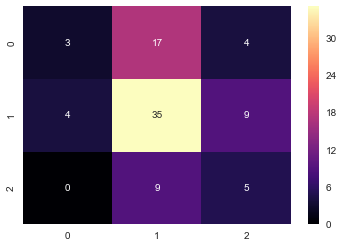

In [33]:
sns.heatmap(cm, cmap='magma', annot=True)

In [34]:
cr = classification_report(y_test, y_predicted)
print(cr)

             precision    recall  f1-score   support

          0       0.43      0.12      0.19        24
          1       0.57      0.73      0.64        48
          2       0.28      0.36      0.31        14

avg / total       0.49      0.50      0.46        86

